#### XG BOOST

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score
)

In [2]:
df = pd.read_csv("student_sleep_patterns.csv")

# Stratified train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])


In [3]:
# Bin Sleep_Quality into 3 categories
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0 = Low, 1 = Medium, 2 = High
train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Create binary label: 1 if High sleep quality, 0 otherwise
train_df['Sleep_Quality_Binary'] = train_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)
test_df['Sleep_Quality_Binary'] = test_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)


In [7]:
# Drop Student_ID if exists
for df_ in [train_df, test_df]:
    df_.drop(columns=[col for col in ['Student_ID'] if col in df_.columns], inplace=True)


In [9]:
# Encode categorical columns
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

In [11]:
# Separate features and target
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_train = train_df['Sleep_Quality_Binary']
X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_test = test_df['Sleep_Quality_Binary']


In [13]:
# Standardize for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral Clustering
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Use RandomForestClassifier to mimic clustering for test set
from sklearn.ensemble import RandomForestClassifier
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)
test_clusters = rf_cluster.predict(X_test)

# Add cluster as a new feature
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [15]:
# Apply SMOTE to balance binary classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [17]:
X_train.head()

,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End,Spectral_Cluster
85,20,1,3,6.0,0.7,2.1,3,52,4.64,6.64,7.72,7.98,1
82,22,0,0,7.0,2.5,1.9,1,75,4.93,3.14,8.94,7.93,1
49,23,0,1,7.3,6.2,2.5,5,1,17.27,7.00,6.50,10.71,1
120,25,2,0,8.4,11.3,2.0,3,96,10.04,6.47,7.59,9.21,2
79,21,2,3,5.7,9.7,2.1,5,103,8.00,4.13,6.82,9.18,2


#### Before Smoting

In [11]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import  RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error



# Setup XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.3)
}

# Hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)
# Fit model to training data
random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Evaluate on full features
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)
print(f"\nTrain Accuracy (all features): {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy (all features): {accuracy_score(y_test, y_test_pred):.4f}")

# Feature importance 
importances = best_xgb.feature_importances_
features = X_train.columns
# Create and sort feature importance dataframe
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Feature selection loop

test_accuracies = []
# Loop through top k features from 1 to all

for k in range(1, len(features) + 1):
    top_features = feat_imp_df['Feature'].iloc[:k].tolist()
    
# Train new XGBoost model on top-k features
    xgb_top = XGBClassifier(random_state=42, eval_metric='logloss', **random_search.best_params_)
    xgb_top.fit(X_train[top_features], y_train)
    y_test_pred_k = xgb_top.predict(X_test[top_features])
# Predict and calculate accuracy
    acc = accuracy_score(y_test, y_test_pred_k)
    test_accuracies.append(acc)

# Find best number of features that gives highest test accuracy
best_k = np.argmax(test_accuracies) + 1
print(f"\nBest number of features: {best_k} with Test Accuracy: {test_accuracies[best_k - 1]:.4f}")

## Final XGBoost with best_k features
best_features = feat_imp_df['Feature'].iloc[:best_k].tolist()
final_xgb = XGBClassifier(random_state=42, eval_metric='logloss', **random_search.best_params_)
final_xgb.fit(X_train[best_features], y_train)

y_train_pred_best = final_xgb.predict(X_train[best_features])
y_test_pred_best = final_xgb.predict(X_test[best_features])

# Evaluation
print(f"\nTrain Accuracy (best features): {accuracy_score(y_train, y_train_pred_best):.4f}")
print(f"Test Accuracy (best features): {accuracy_score(y_test, y_test_pred_best):.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_best))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_best))

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'colsample_bytree': 0.6360661246923176, 'gamma': 0.1943070361624087, 'learning_rate': 0.010156113098594747, 'max_depth': 7, 'n_estimators': 332, 'subsample': 0.6523906290790145}

Train Accuracy (all features): 0.9550
Test Accuracy (all features): 0.7100

Best number of features: 3 with Test Accuracy: 0.7200

Train Accuracy (best features): 0.7225
Test Accuracy (best features): 0.7200

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        71
           1       1.00      0.03      0.07        29

    accuracy                           0.72       100
   macro avg       0.86      0.52      0.45       100
weighted avg       0.80      0.72      0.61       100

Confusion Matrix (Test):
[[71  0]
 [28  1]]
Train RMSE: 0.5268
Test RMSE: 0.5292


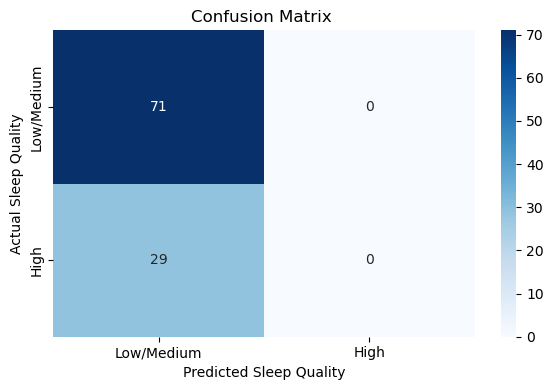

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Correct labels based on your binary target
labels = ['Low/Medium', 'High']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sleep Quality')
plt.ylabel('Actual Sleep Quality')
plt.title('Confusion Matrix ')

# Save the plot
plt.tight_layout()
plt.savefig("before smote xgboost.png")
plt.show()


#####  After Smoting

In [37]:
#vimukthi code
from sklearn.model_selection import  RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error



# XGBoost setup
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.3)
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_xgb_s = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Predictions on full feature set
y_train_pred = best_xgb_s.predict(X_train)
y_test_pred = best_xgb_s.predict(X_test)
print(f"\nTrain Accuracy (all features): {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy (all features): {accuracy_score(y_test, y_test_pred):.4f}")

# Feature importance ranking
importances = best_xgb_s.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Test accuracy for different k
test_accuracies = []
for k in range(1, len(features) + 1):
    top_features = feat_imp_df['Feature'].iloc[:k].tolist()
    xgb_top = XGBClassifier(random_state=42, eval_metric='logloss', **random_search.best_params_)
    xgb_top.fit(X_train[top_features], y_train)
    y_test_pred_k = xgb_top.predict(X_test[top_features])
    acc = accuracy_score(y_test, y_test_pred_k)
    test_accuracies.append(acc)

best_k = np.argmax(test_accuracies) + 1
print(f"\nBest number of features: {best_k} with Test Accuracy: {test_accuracies[best_k - 1]:.4f}")

# Final XGBoost with best_k features
best_features = feat_imp_df['Feature'].iloc[:best_k].tolist()
final_xgb = XGBClassifier(random_state=42,  eval_metric='logloss', **random_search.best_params_)
final_xgb.fit(X_train[best_features], y_train)

y_train_pred_best = final_xgb.predict(X_train[best_features])
y_test_pred_best = final_xgb.predict(X_test[best_features])

# Evaluation
print(f"\nTrain Accuracy (best features): {accuracy_score(y_train, y_train_pred_best):.4f}")
print(f"Test Accuracy (best features): {accuracy_score(y_test, y_test_pred_best):.4f}")
print("\nClassification Report XgBoost (Test):")
print(classification_report(y_test, y_test_pred_best))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_best))

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'colsample_bytree': 0.5507357714330161, 'gamma': 0.19905053073241674, 'learning_rate': 0.011518475153865606, 'max_depth': 8, 'n_estimators': 437, 'subsample': 0.7428068767931133}

Train Accuracy (all features): 1.0000
Test Accuracy (all features): 0.6500

Best number of features: 7 with Test Accuracy: 0.7400

Train Accuracy (best features): 0.9575
Test Accuracy (best features): 0.7400

Classification Report XgBoost (Test):
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        71
           1       1.00      0.10      0.19        29

    accuracy                           0.74       100
   macro avg       0.87      0.55      0.52       100
weighted avg       0.81      0.74      0.65       100

Confusion Matrix (Test):
[[71  0]
 [26  3]]
Train RMSE: 0.2062
Test RMSE: 0.5099


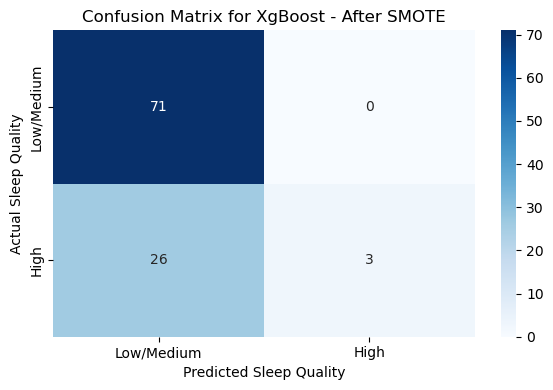

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_best)

# Correct labels based on your binary target
labels = ['Low/Medium', 'High']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sleep Quality')
plt.ylabel('Actual Sleep Quality')
plt.title('Confusion Matrix for XgBoost - After SMOTE')

# Save the plot
plt.tight_layout()
plt.savefig("aftersmotexgboost.png")
plt.show()

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = best_xgb_s.feature_importances_
features = X_train.columns  # use the same feature names used for training

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp_df.head(20),
    x='Importance',
    y='Feature',
    hue='Feature',        
    legend=False,
    palette='Blues_r'
)
plt.title('Top 20 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()


NameError: name 'best_xgb_s' is not defined

In [17]:
#!pip install shap

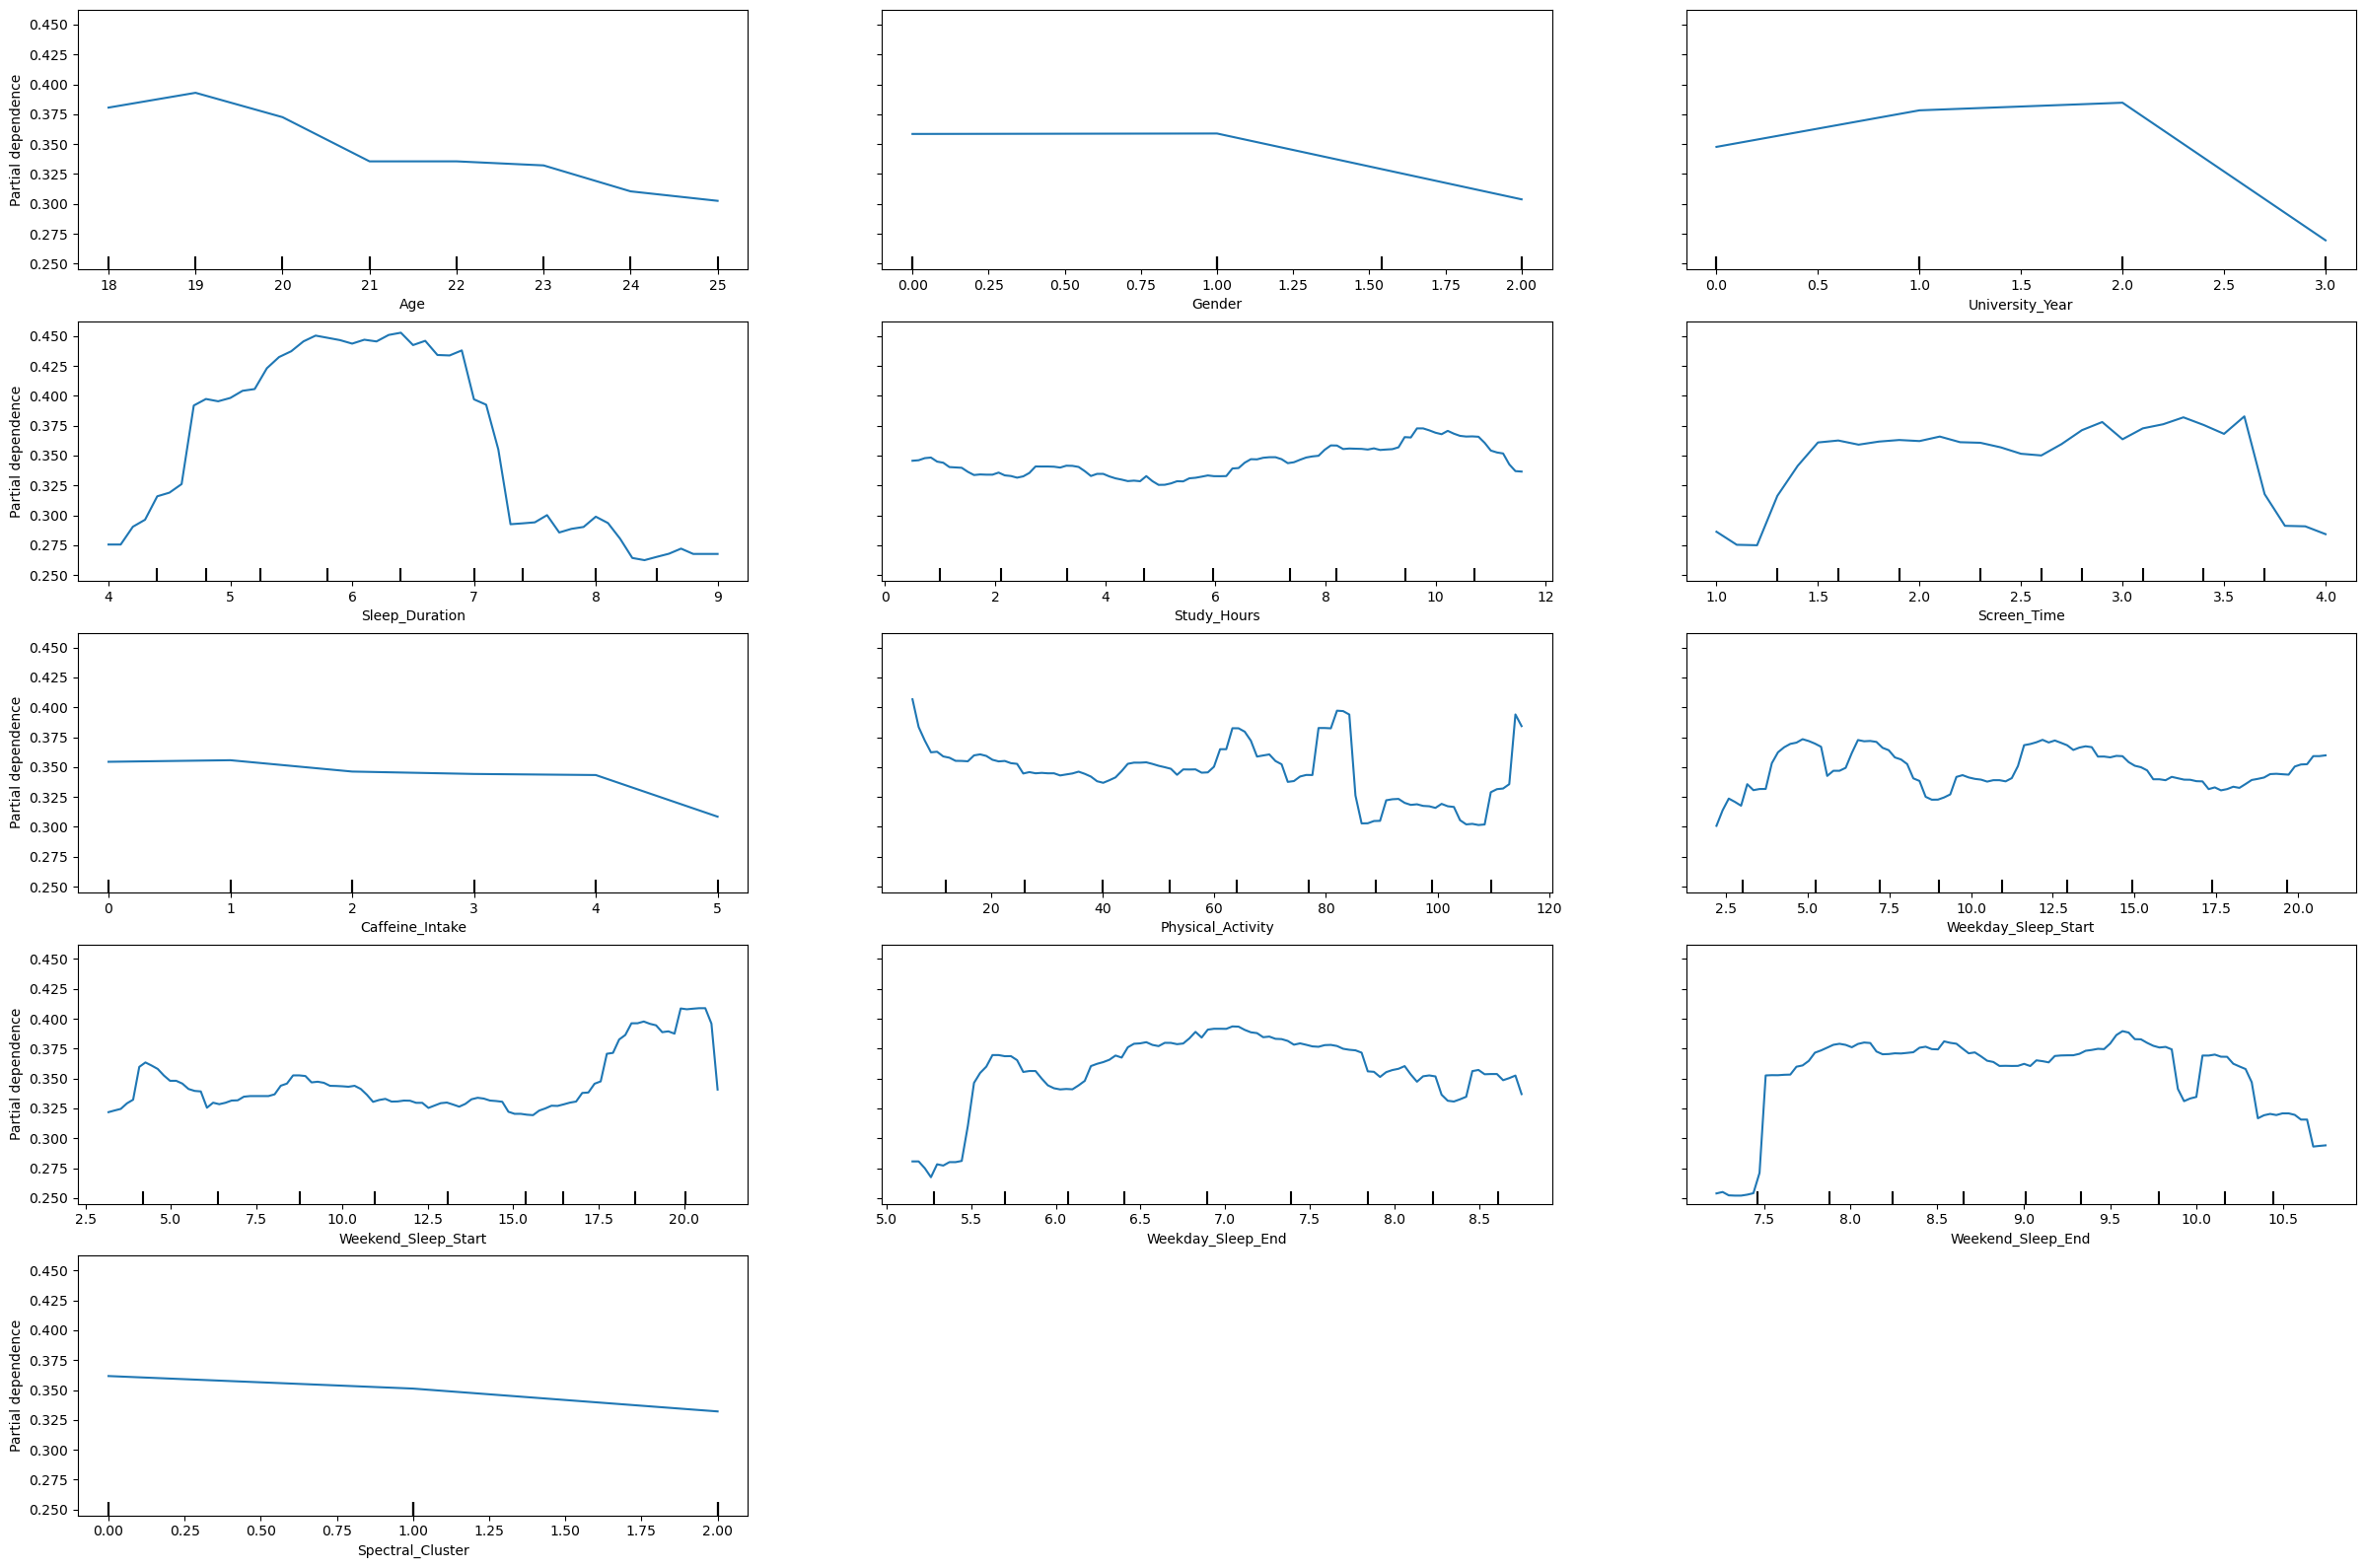

In [18]:
# for patial dependency plots
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select top features 
features_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  

# Plot PDP
fig, ax = plt.subplots(figsize=(24, 16))
PartialDependenceDisplay.from_estimator(best_xgb_s, X_train, features_to_plot, ax=ax)
plt.tight_layout()
plt.show()

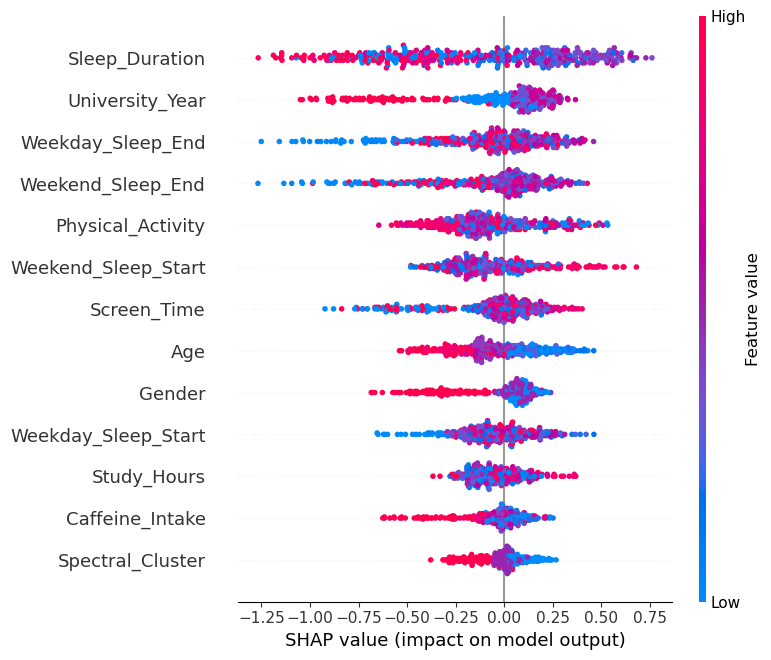

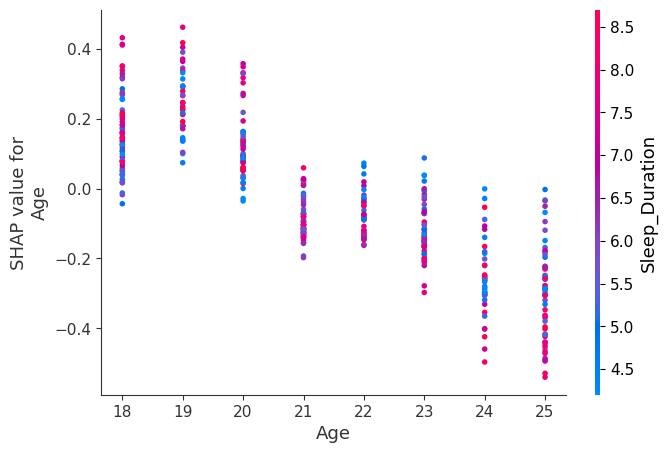

In [19]:
import shap

# Explain the model's predictions using SHAP

explainer = shap.Explainer(best_xgb_s)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)
shap.dependence_plot(0, shap_values.values, X_train) 